## Synthetic Q learning

In this experiment, we check how well different Q learning methods do in recovering a ground truth Q matrix.
We will consider different Q matrix types:

1. Every item has exactly one skill.
2. Every item can have multiple skills, but the strength is equal.
3. Every item can have multiple skills, and the connection strength varies.

Further, we vary the following parameters:

1. number of students.
2. number of items.
3. discrimination parameter.
4. fraction of nan entries.

Student abilities and item difficulties are always sampled form a standard normal distribution. We always consider five skills.

In [1]:
import numpy as np
from numpy.random import default_rng
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
from sklearn import metrics

rng = default_rng()

# set up experimental meta-parameters
num_trials   = 10
num_skills   = 5
num_test_students = 100

exp_param_labels = ['num_students', 'num_items', 'discrimination', 'nans']
# in each tuple, the first entry is the default value for the respective experimental parameter,
# and the second entry is a list of values we will try
exp_params = [
    (100, [20, 50, 100, 500, 1000]),
    (20, [10, 20, 50, 100]),
    (1, [0.5, 1., 2., 4.]),
    (0., [0., .1, .2, .3, .5, .9])
]

# set up method hyperparams that we should try
method_labels = ['SPARFA', 'VIBO', 'QFactor', 'Q2Factor']
hyperparams     = [(1E-5, 1E-3, 1E-3), (1E-4, 5E-2,1E-3), (1E-3, 1., 1E-3), (1E-2, 5E-2, 5E-2), (1E-1, 1., 5E-2), (1., 1., 1.)]


### Sampling Functions

In [2]:
def sample_Q(condition, num_items, num_skills):
    """ Randomly samples a Q matrix 

    Parameters
    ----------
    condition: int (either 1, 2, or 3)
        The condition under which the Q matrix is sampled. See documentation above.
    num_items: int
        The number of items.
    num_skills: int
        The number of latent skills.

    Returns
    -------
    Q: ndarrray
        A num_items x num_skills matrix of item-to-skill associations.

    """
    Q = np.zeros((num_items, num_skills))
    # sample number of skills for each item
    if condition == 1:
        Ks = np.ones(num_items, dtype=int)
    else:
        possible_Ks = np.arange(1, num_skills+1, dtype=int)
        p = num_skills+1-possible_Ks
        p = p / np.sum(p)
        Ks = rng.choice(possible_Ks, size = num_items, p = p)
    for j in range(num_items):
        # sample skills for this item
        ks = rng.choice(num_skills, size = Ks[j], replace = False)
        # sample connection strength
        if condition == 3:
            Q[j, ks] = 0.5 * (1 + rng.random(size = Ks[j]))
        else:
            Q[j, ks] = 1.
    return Q

def sample_data(Q, num_students, b = None, discrimination = 1., nans = 0.):
    """ Randomly student abilities, item difficulties, and responses.

    Parameters
    ----------
    Q: ndarray
        A num_items x num_skills matrix of item-to-skill associations.
    num_students: int
        The number of students.
    b: ndarray (default = None)
        If given, difficulties are not sampled anew but re-used.
    discrimination: float (positive; default = 1.)
        The higher this number, the more strictly the response matrix
        will reflect the difference of student skill and item difficulty.
    nans: float (between 0. and 1.; default = 0.)
        The rate of nan entries in X.

    Returns
    -------
    Theta: ndarrray
        A num_students x num_skills matrix of student abilities for each
        skill (all standard normal).
    b: ndarray
        A num_items vector of item difficulties (standard normal).
    X: ndarray
        A num_students x num_items matrix of student responses, where X[i, j] = 1
        if student i responded correctly to item j, and X[i, j] = 0, otherwise.
        X[i, j] is one wit probability
        sigma(discrimination * (Q[j, :] * Theta[i, :] - b[j]))
        where sigma is the logistic function.

    """
    num_items, num_skills = Q.shape
    # sample student abilities
    Theta = rng.standard_normal(size = (num_students, num_skills))
    # sample item difficulties
    if b is None:
        b = rng.standard_normal(size = num_items)
    # compute logits
    Z = np.dot(Theta, Q.T) - np.expand_dims(b, 0)
    # compute success probabilities
    P = 1. / (1. + np.exp(-discrimination * Z))
    # sample responses
    X = rng.random(size = (num_students, num_items))
    X[X > 1. - P]  = 1.
    X[X <= 1. - P] = 0.
    # mask out nans
    if nans > 0.:
        R = rng.random(size = (num_students, num_items))
        X[R > 1. - nans] = np.nan
    return Theta, b, X

### Evaluation functions

In [3]:
eval_labels = ['theta_r', 'b_r', 'Q_l2', 'Q_l0', 'acc', 'auc', 'train_time', 'pred_time']

def evaluate_Theta(Theta_true, Theta_pred):
    """ Computes linear correlation between true Theta and predicted Theta while
    permitting column-reordering.
    
    Parameters
    ----------
    Theta_true: ndarray
        A ground truth num_students x num_skills ability matrix.
    Theta_pred: ndarray
        A predicted num_students x num_skills ability matrix.

    Returns
    -------
    r: float
        The average pearson correlation coefficient across columns.

    """
    # compute pairwise linear correlations
    K = Theta_true.shape[1]
    R = np.zeros((K, K))
    for k in range(K):
        for l in range(K):
            if np.std(Theta_true[:, k]) < 1E-3 or np.std(Theta_pred[:, l]) < 1E-3:
                R[k, l] = 0.
                continue
            R[k, l], _ = pearsonr(Theta_true[:, k], Theta_pred[:, l])
    # find optimal column assignment via linear_sum_assignment
    Costs = 1. - R
    rows, cols = linear_sum_assignment(Costs)
    r     = np.mean(R[rows, cols])
    return r

def evaluate_b(btrue, bpred):
    """ Computes linear correlation between true and predicted difficulties.
    
    Parameters
    ----------
    b_true: ndarray
        A ground truth num_items difficulty vector.
    b_pred: ndarray
        A predicted num_items difficulty vector.

    Returns
    -------
    r: float
        The pearson correlation between both inputs.

    """
    r, _ = pearsonr(btrue, bpred)
    return r

def evaluate_Q(Qtrue, Qpred, threshold = 0.1):
    """ Computes the distance between both Q matrices while permitting column re-ordering.

    This can also be viewed as the 2-Wasserstein distance and the 0-Wasserstein-
    distance between the matrices.

    Parameters
    ----------
    Qtrue: ndarray
        A ground truth num_items x num_skills matrix.
    Qpred: ndarray
        An estimated num_items x num_skills matrix.
    threhold: float
        Threshold below which an entry is considered zero for the purpose of the l0
        distance.

    Returns
    -------
    l2: float
        squared L2 distance between both Q matrices.
    l0: float
        l0 distance between both Q matrices, i.e. whether the sparsity pattern is
        equal.

    """
    # L2-normalize the columns
    Qtrue2 = Qtrue / np.expand_dims(1E-3 + np.sqrt(np.sum(np.square(Qtrue), 0)), 0)
    Qpred2 = Qpred / np.expand_dims(1E-3 + np.sqrt(np.sum(np.square(Qpred), 0)), 0)
    # compute optimal assignment
    Cost   = cdist(Qtrue2.T, Qpred2.T) ** 2
    rows, cols = linear_sum_assignment(Cost)
    l2     = np.sum(Cost[rows, cols])
    # process Q matrices with heaviside function
    Qtrueh = np.copy(Qtrue)
    Qtrueh[Qtrue >  0.1] = 1.
    Qtrueh[Qtrue <= 0.1] = 0.
    Qpredh = np.copy(Qpred)
    Qpredh[Qpred >  0.1] = 1.
    Qpredh[Qpred <= 0.1] = 0.
    # compute optimal assignment
    Cost   = cdist(Qtrueh.T, Qpredh.T) ** 2
    rows, cols = linear_sum_assignment(Cost)
    l0     = np.sum(Cost[rows, cols])
    return l2, l0

def evaluate_X(Xtrue, Ppred):
    # flatten and remove nans
    xtrue = np.ravel(Xtrue)
    nonnans = np.logical_not(np.isnan(xtrue))
    ppred = np.ravel(Ppred)
    xtrue = xtrue[nonnans]
    ppred = ppred[nonnans]
    # compute accuracy
    acc   = 1. - np.mean(np.abs(xtrue - np.round(ppred)))
    # compute AUC
    pos_label = 1.
    fpr, tpr, _ = metrics.roc_curve(xtrue, ppred, pos_label=pos_label)
    auc   = metrics.auc(fpr, tpr)
    return acc, auc

## Start of actual experiment

In [4]:
import os
from tqdm import tqdm
import time

import sparfa
import vibo
import sparfae

# iterate over the conditions
for condition in range(1, 4):
    
    # iterate over the hyperparameters
    for param in range(len(exp_param_labels)):
        # set up result tensor for current experimental condition
        Res = np.full((len(exp_params[param][1]), len(hyperparams), len(method_labels), len(eval_labels), 2), np.nan)

        # try to load partial results
        results_file_name = 'synthetic_results/%s_%d.csv' % (exp_param_labels[param], condition)
        if os.path.isfile(results_file_name):
            datamat = np.loadtxt(results_file_name, delimiter = '\t', skiprows = 1)
            row = 0
            for val in range(len(exp_params[param][1])):
                for hyperpar in range(len(hyperparams)):
                    col = 4
                    for method in range(len(method_labels)):
                        for eva in range(len(eval_labels)):
                            Res[val, hyperpar, method, eva, 0] = datamat[row, col]
                            Res[val, hyperpar, method, eva, 1] = datamat[row, col+1]
                            col += 2
                    row += 1

        # iterate over experimental parameter values
        for val in range(len(exp_params[param][1])):
            if not np.any(np.isnan(Res[val, :, :, :])):
                continue
            print('--- condition %d; %s: %g ---' % (condition, exp_param_labels[param], exp_params[param][1][val]))
            
            num_students   = exp_params[0][1][val] if param == 0 else exp_params[0][0]
            num_items      = exp_params[1][1][val] if param == 1 else exp_params[1][0]
            discrimination = exp_params[2][1][val] if param == 2 else exp_params[2][0]
            nans           = exp_params[3][1][val] if param == 3 else exp_params[3][0]
            # set up result tensor for the current experimental condition
            res = np.zeros((len(hyperparams), len(method_labels), len(eval_labels), num_trials))
            # iterate over trials
            for trial in tqdm(range(num_trials)):
                # simulate a new data set for the current experimental condition
                Q = sample_Q(condition, num_items, num_skills)
                _, b, Xtrain    = sample_data(Q, num_students, None, discrimination, nans)
                Theta, _, Xtest = sample_data(Q, num_test_students, b, discrimination, nans)
                # iterate over model hyperparams
                for hyperpar in range(len(hyperparams)):
                    vae_regul, l1regul, l2regul = hyperparams[hyperpar]
                    # iterate over models
                    for method in range(len(method_labels)):
                        start = time.time()
                        if method_labels[method] == 'SPARFA':
                            model = sparfa.SPARFA(num_skills, l1regul = l1regul, l2regul = l2regul)
                        elif method_labels[method] == 'VIBO':
                            model = vibo.VIBO(num_items, num_skills, num_epochs = 100, lr = 5E-3, minibatch_size = 16, regul = vae_regul)
                        elif method_labels[method] == 'QFactor':
                            model = sparfae.QFactorModel(num_skills, l1regul = l1regul, l2regul = l2regul)
                        elif method_labels[method] == 'Q2Factor':
                            model = sparfae.QTwoFactorModel(num_skills, l1regul = l1regul, l2regul = l2regul)
                        else:
                            raise ValueError('unknown method')
                        # train the model
                        model.fit(Xtrain)
                        res[hyperpar, method, 6, trial] = time.time() - start
                        # predict on test data
                        start = time.time()
                        Thetapred = model.encode(Xtest)
                        Ppred = model.decode_proba(Thetapred)
                        res[hyperpar, method, 7, trial] = time.time() - start

                        # evaluate Theta
                        res[hyperpar, method, 0, trial] = evaluate_Theta(Theta, Thetapred)
                        # evaluate b
                        res[hyperpar, method, 1, trial] = evaluate_b(b, model.difficulties())
                        # evaluate Q
                        res[hyperpar, method, 2, trial], res[hyperpar, method, 3, trial] = evaluate_Q(Q, model.Q())
                        # evaluate accuracy and AUC
                        res[hyperpar, method, 4, trial], res[hyperpar, method, 5, trial] = evaluate_X(Xtest, Ppred)
            # compute mean and std over trials
            Res[val, :, :, :, 0] = np.mean(res, 3)
            Res[val, :, :, :, 1] = np.std(res, 3)
            # store results
            header = [exp_param_labels[param], 'vae_regul', 'l1regul', 'l2regul']
            datamat = [np.repeat(exp_params[param][1], len(hyperparams))]
            for hyperpar in range(3):
                datamat.append(np.tile(np.array(hyperparams)[:, hyperpar], len(exp_params[param][1])))
            for method in range(len(method_labels)):
                for eva in range(len(eval_labels)):
                    header.append('%s_%s_mean' % (method_labels[method], eval_labels[eva]))
                    datamat.append(np.ravel(Res[:, :, method, eva, 0]))
                    header.append('%s_%s_std' % (method_labels[method], eval_labels[eva]))
                    datamat.append(np.ravel(Res[:, :, method, eva, 1]))
            datamat = np.stack(datamat, 1)
            np.savetxt(results_file_name, datamat, fmt = '%g', delimiter = '\t', header = '\t'.join(header), comments = '')

## Result visualizations

In [5]:
# utility function to get the header form a CSV file
import csv

def get_header(filename):
    with open(filename) as f:
        reader = csv.reader(f, delimiter = '\t')
        return reader.__next__()

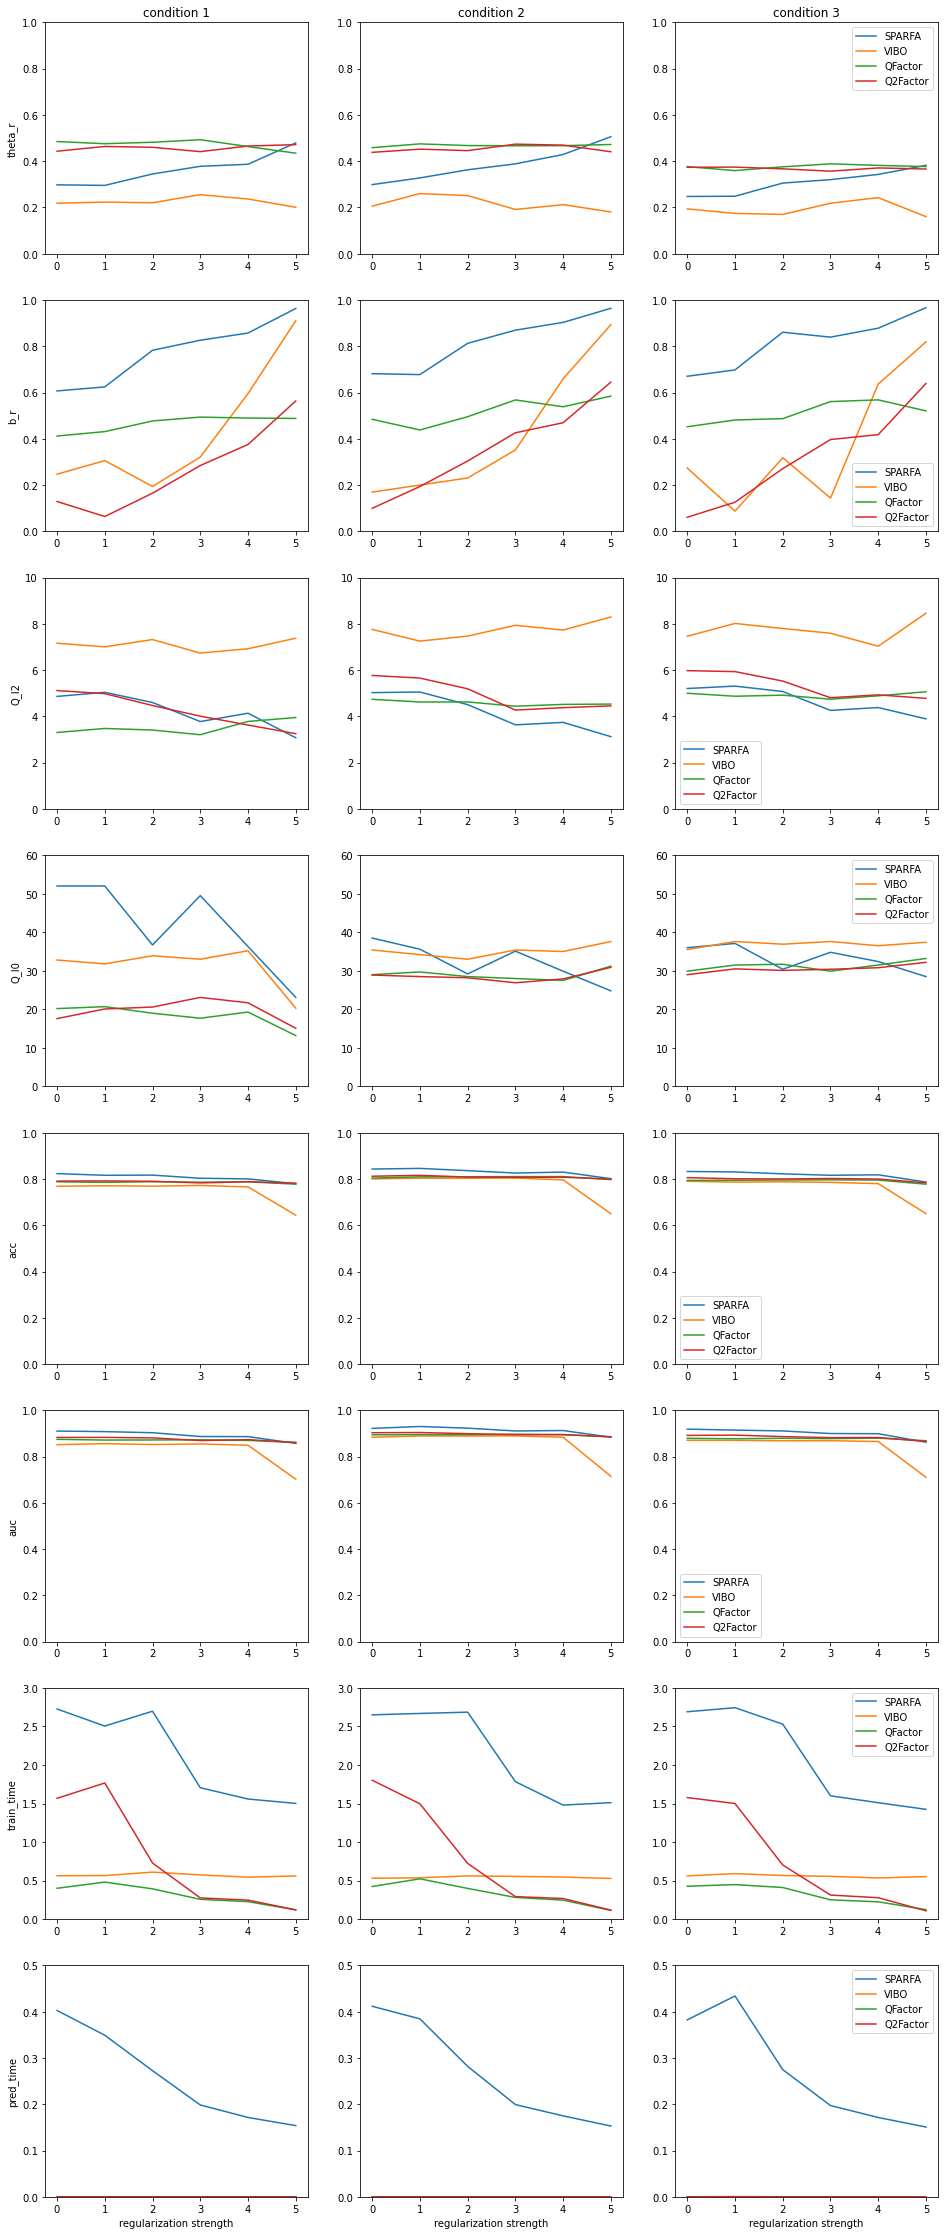

In [6]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize = (16, 5 * len(eval_labels)))

# the maximum y axis values for plotting for each evaluation measure
max_levels = [1., 1., 10., 60., 1., 1., 3., 0.5]

# show how evaluation measures vary with regularization for 'default' experimental condition
for condition in range(1, 4):
    # get results from the 'nan' file because there the default parameter is right on top
    results_file_name = 'synthetic_results/nans_%d.csv' % condition
    # load header
    header = get_header(results_file_name)
    # load data
    res = np.loadtxt(results_file_name, delimiter = '\t', skiprows = 1)[:len(hyperparams), :]
    # plot data for each evaluation measure
    for eva in range(len(eval_labels)):
        plt.subplot(len(eval_labels), 3, eva * 3 + condition)
        for method in range(len(method_labels)):
            col_header = '%s_%s_mean' % (method_labels[method], eval_labels[eva])
            j = header.index(col_header)
            plt.plot(res[:, j])
        if eva == 0:
            plt.title('condition %d' % condition)
        elif eva == len(eval_labels)-1:
            plt.xlabel('regularization strength')
        if condition == 1:
            plt.ylabel(eval_labels[eva])
        elif condition == 3:
            plt.legend(method_labels)
        plt.ylim(0, max_levels[eva])
plt.show()

In [7]:
# show how evaluation measures vary with experimental hyperparameters

# define a plot function
def plot_for_experimental_hyperparam(exp_param_label, max_levels, ref_eva = 'auc'):
    exp_param       = exp_param_labels.index(exp_param_label)
    param_range     = exp_params[exp_param][1]

    # the reference evaluation measure for hyperparam selection
    ref_eva         = eval_labels.index(ref_eva)
    plt.figure(figsize = (16, 5 * len(eval_labels)))

    # iterate over conditions
    for condition in range(1, 4):
        # load results file
        results_file_name = 'synthetic_results/%s_%d.csv' % (exp_param_label, condition)
        # load header
        header = get_header(results_file_name)
        # load data
        res = np.loadtxt(results_file_name, delimiter = '\t', skiprows = 1)
        # reshape data to to make it more manageable
        res2 = np.zeros((len(param_range), len(hyperparams), len(method_labels), len(eval_labels)))
        for method in range(len(method_labels)):
            for eva in range(len(eval_labels)):
                col_header = '%s_%s_mean' % (method_labels[method], eval_labels[eva])
                j = header.index(col_header)
                res2[:, :, method, eva] = res[:, j].reshape((len(param_range), len(hyperparams)))

        # for each method, select the best hyperparameter
        opt_hyper = np.argmax(res2[:, :, :, ref_eva], 1)
        # plot data for each evaluation measure
        for eva in range(len(eval_labels)):
            plt.subplot(len(eval_labels), 3, eva * 3 + condition)
            min_level = np.inf
            for method in range(len(method_labels)):
                res_series = res2[np.arange(len(param_range)), opt_hyper[:, method], method, eva]
                if 'time' in eval_labels[eva]:
                    min_level = min(min_level, np.min(res_series))
                    plt.loglog(param_range, res_series)
                else:
                    plt.plot(param_range, res_series)
            if eva == 0:
                plt.title('condition %d' % condition)
            elif eva == len(eval_labels)-1:
                plt.xlabel(exp_param_label)
            if condition == 1:
                plt.ylabel(eval_labels[eva])
            elif condition == 3:
                plt.legend(method_labels)
            if 'time' in eval_labels[eva]:
                plt.ylim(10 ** (np.floor(np.log10(min_level))), max_levels[eva])
            else:
                plt.ylim(0, max_levels[eva])
    plt.show()

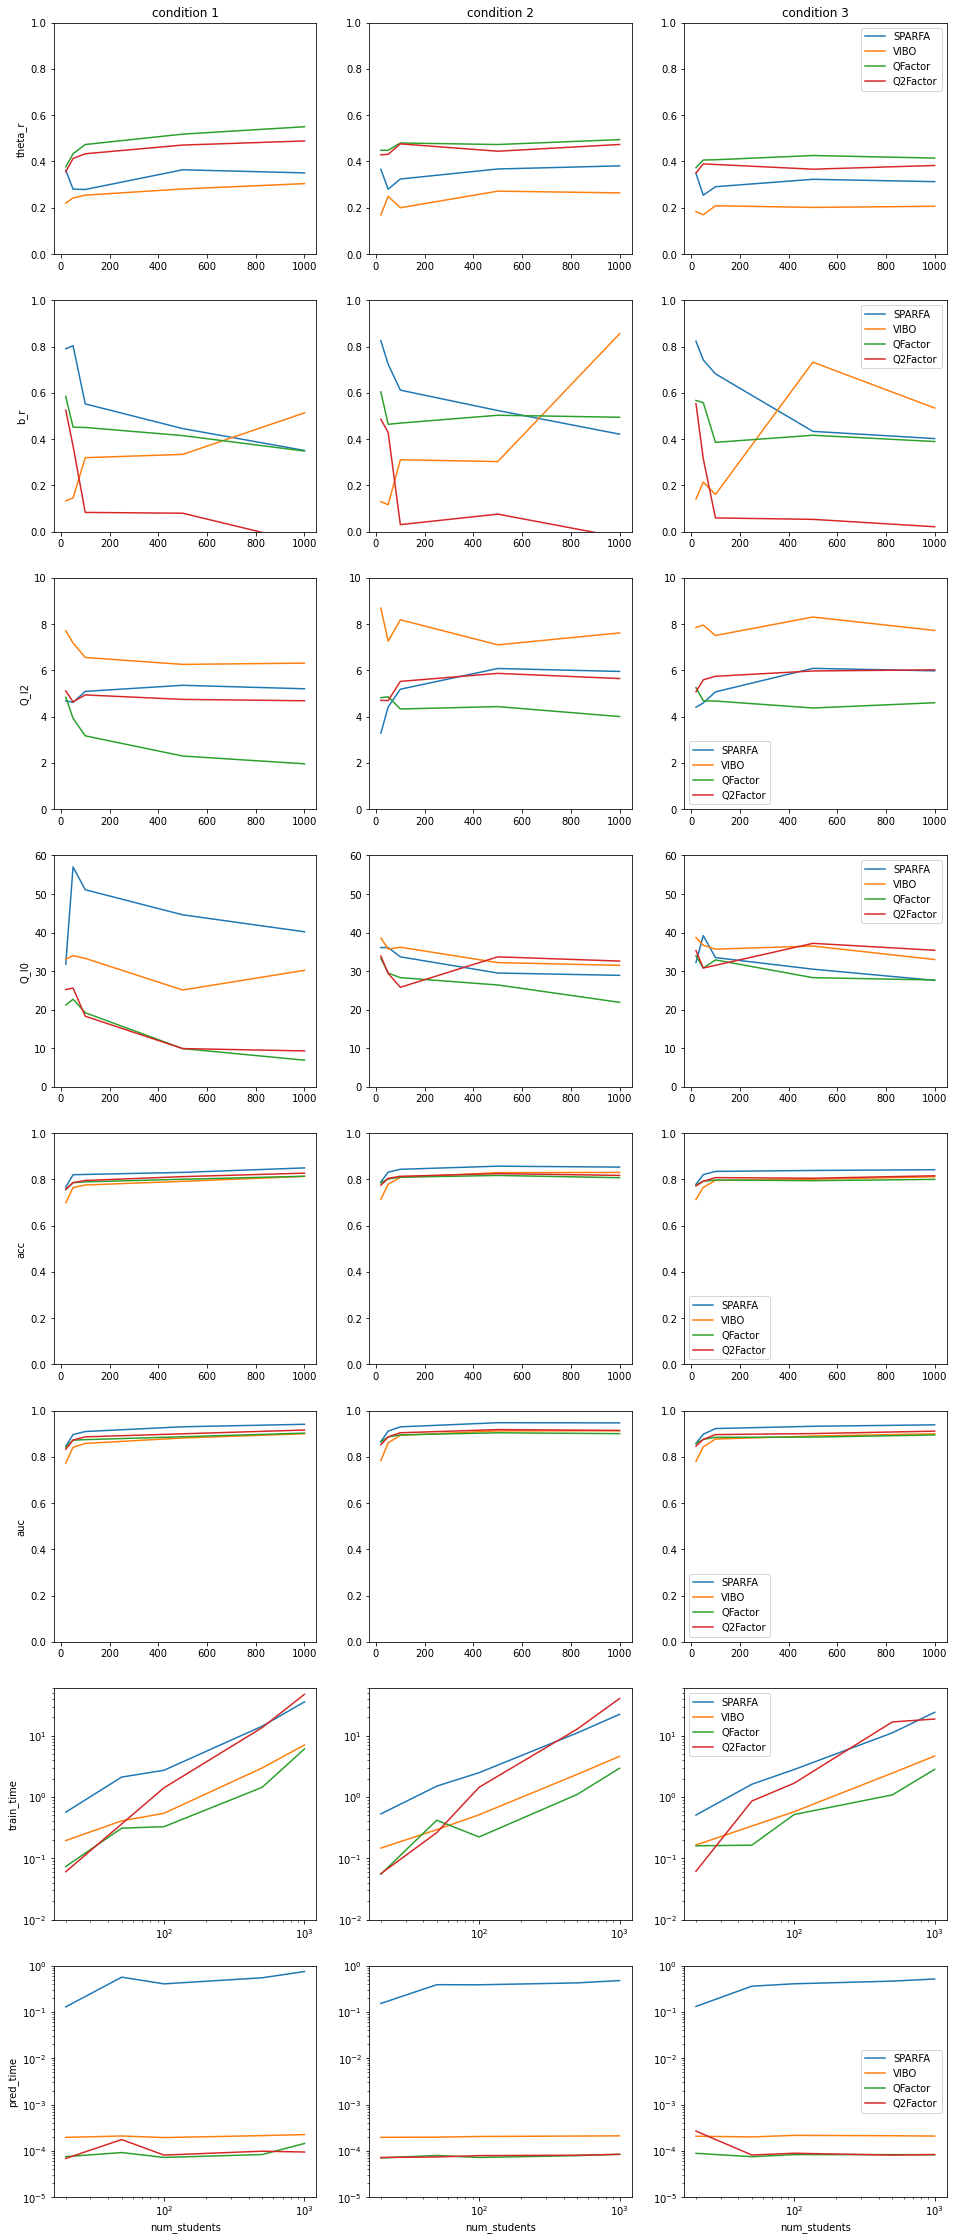

In [8]:
# plot for number of students

exp_param_label = 'num_students'
# the maximum y axis values for plotting for each evaluation measure
max_levels = [1., 1., 10., 60., 1., 1., 60., 1.]

plot_for_experimental_hyperparam(exp_param_label, max_levels)

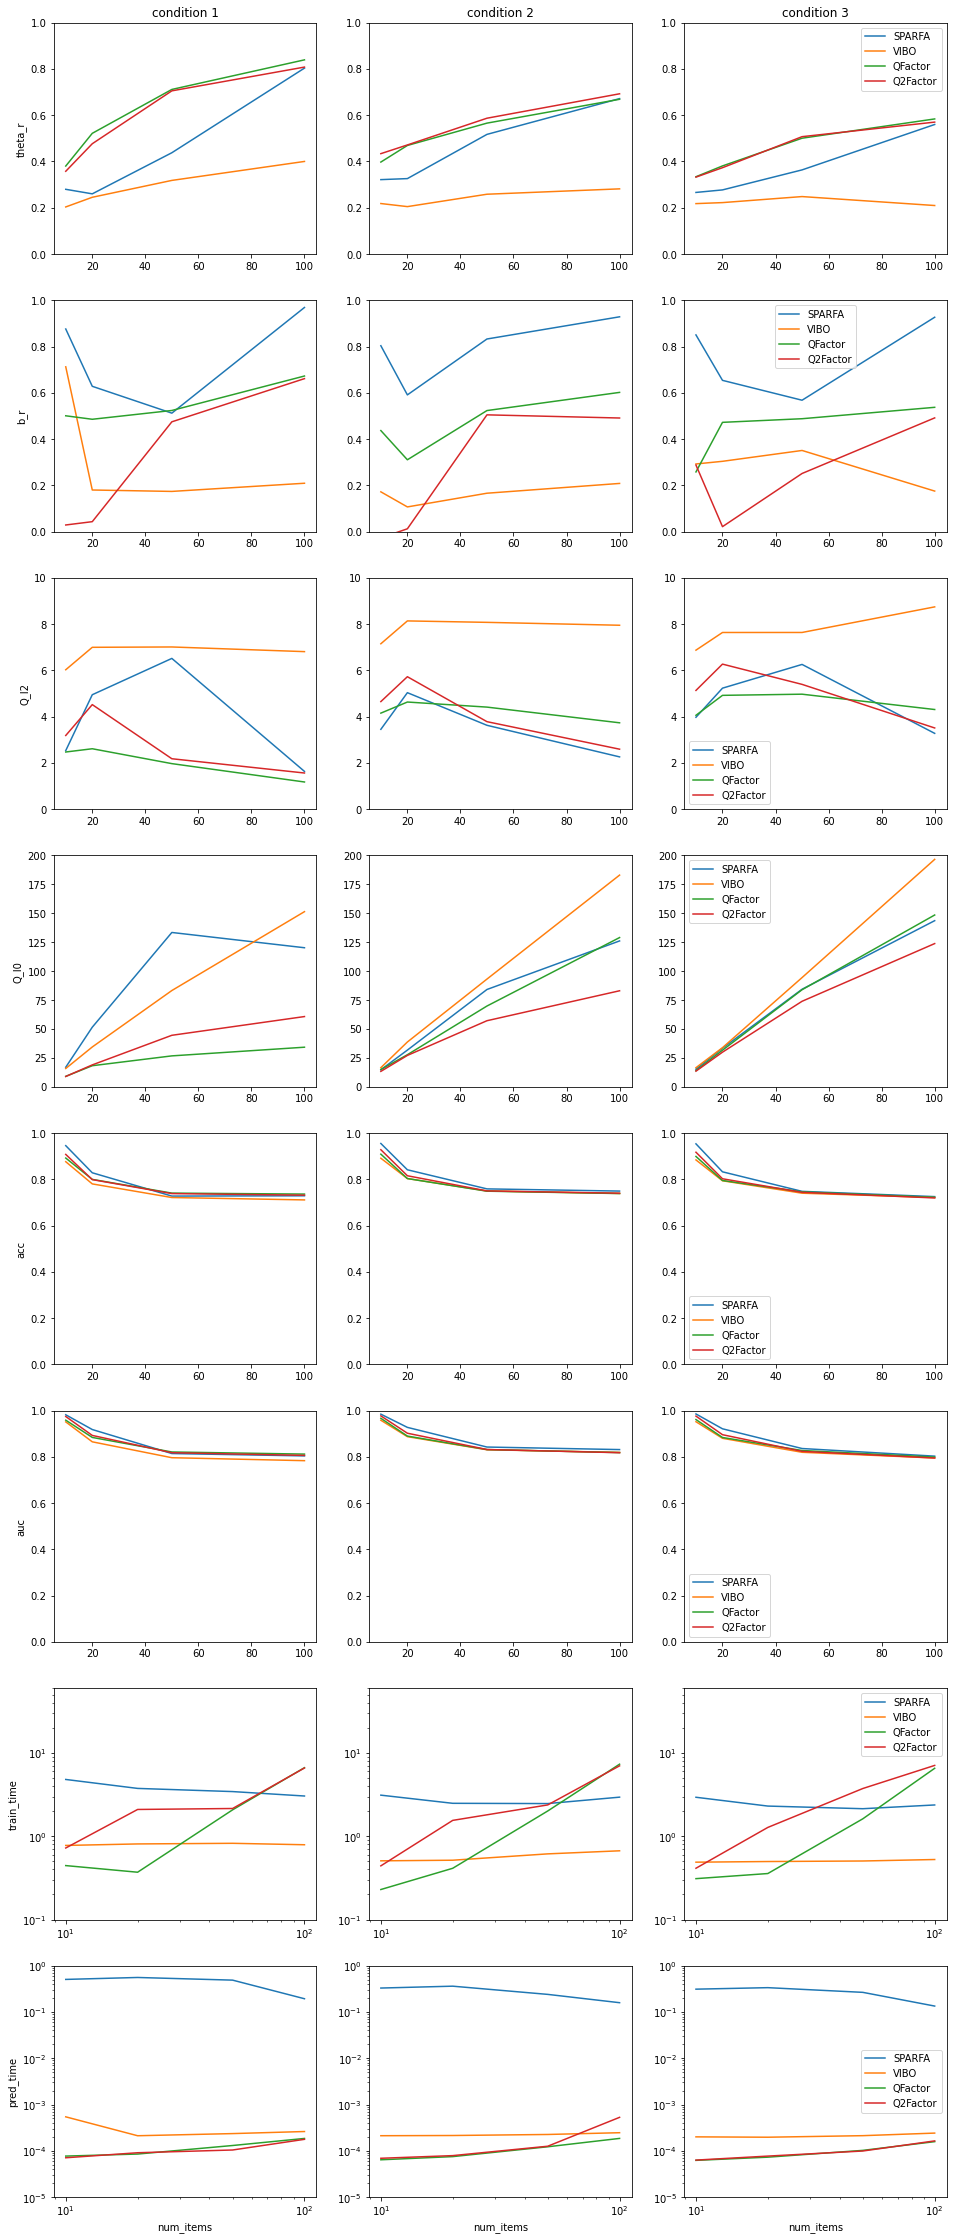

In [9]:
# plot for number of items

exp_param_label = 'num_items'
# the maximum y axis values for plotting for each evaluation measure
max_levels = [1., 1., 10., 200., 1., 1., 60., 1.]

plot_for_experimental_hyperparam(exp_param_label, max_levels)

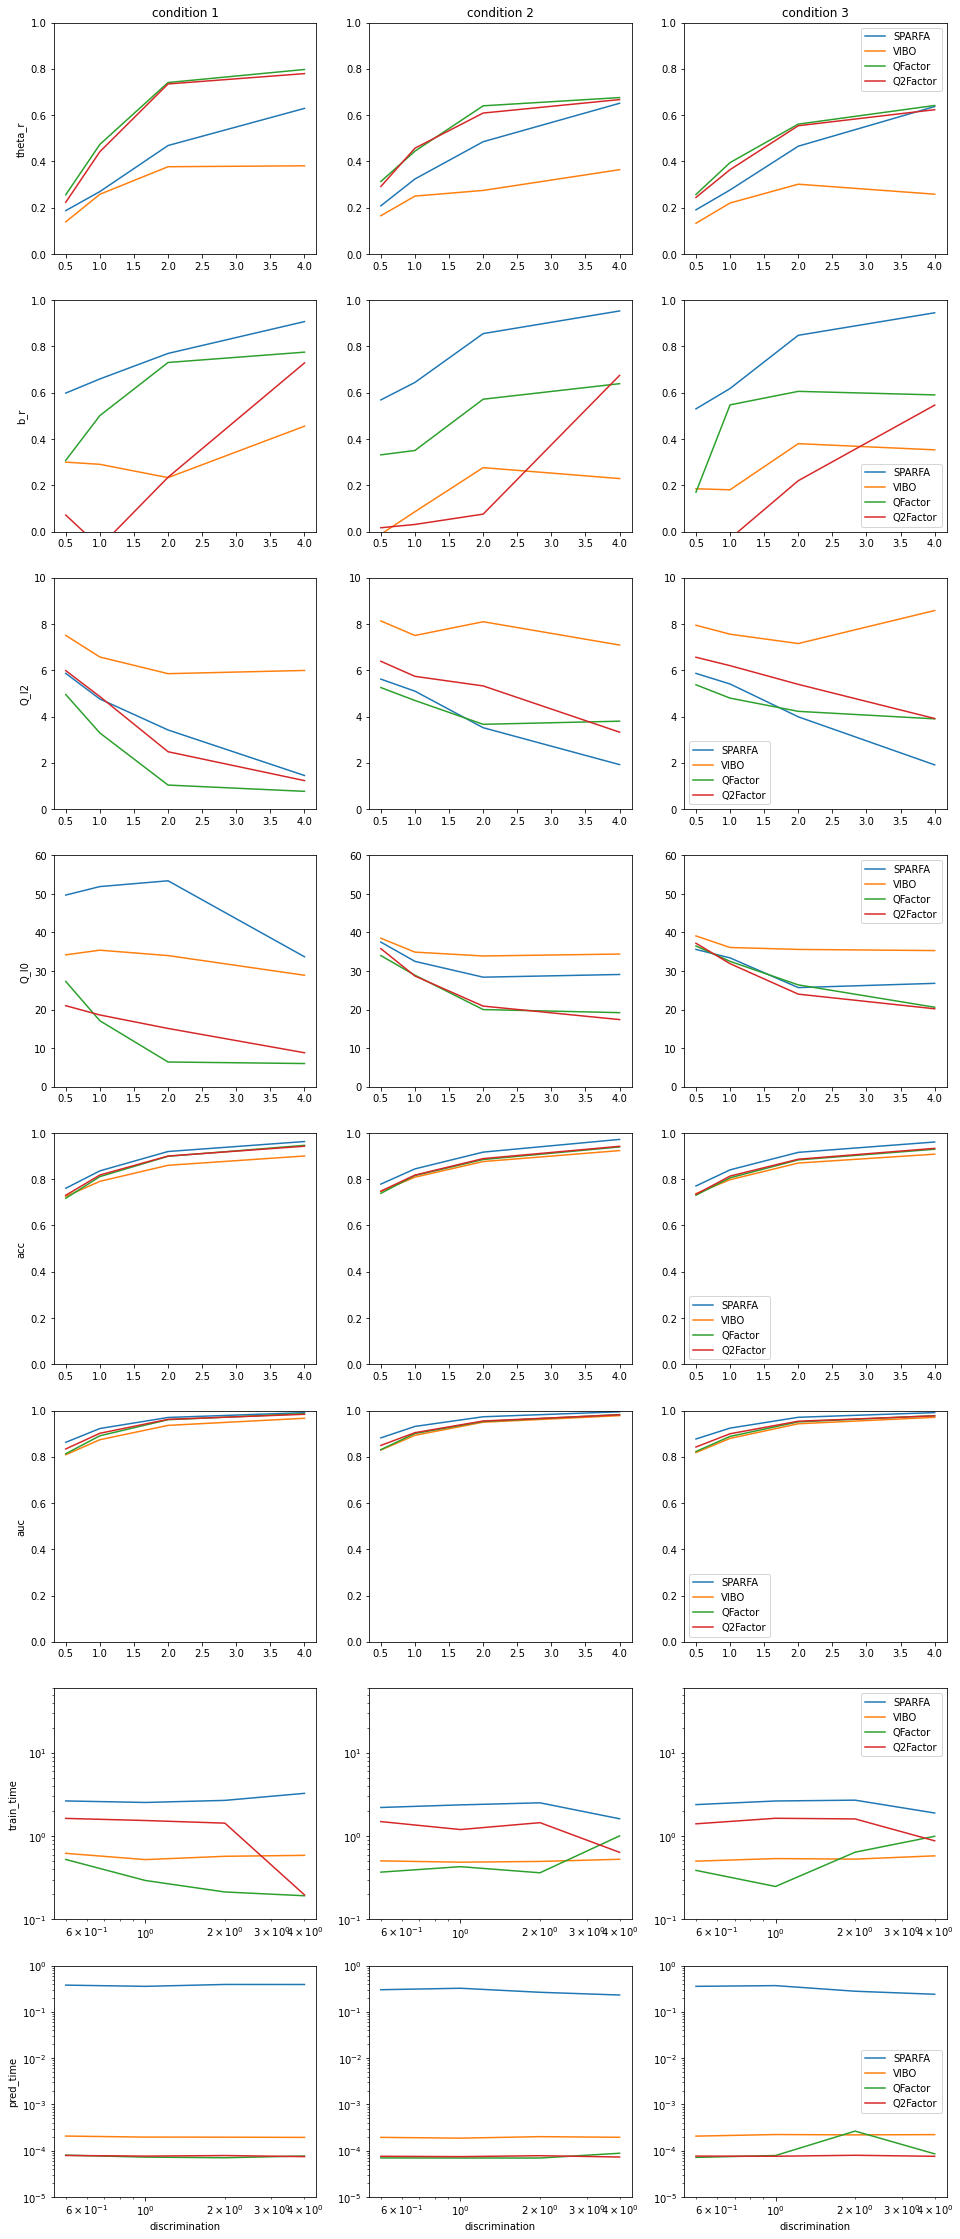

In [10]:
# plot for discrimination

exp_param_label = 'discrimination'
# the maximum y axis values for plotting for each evaluation measure
max_levels = [1., 1., 10., 60., 1., 1., 60., 1.]

plot_for_experimental_hyperparam(exp_param_label, max_levels)

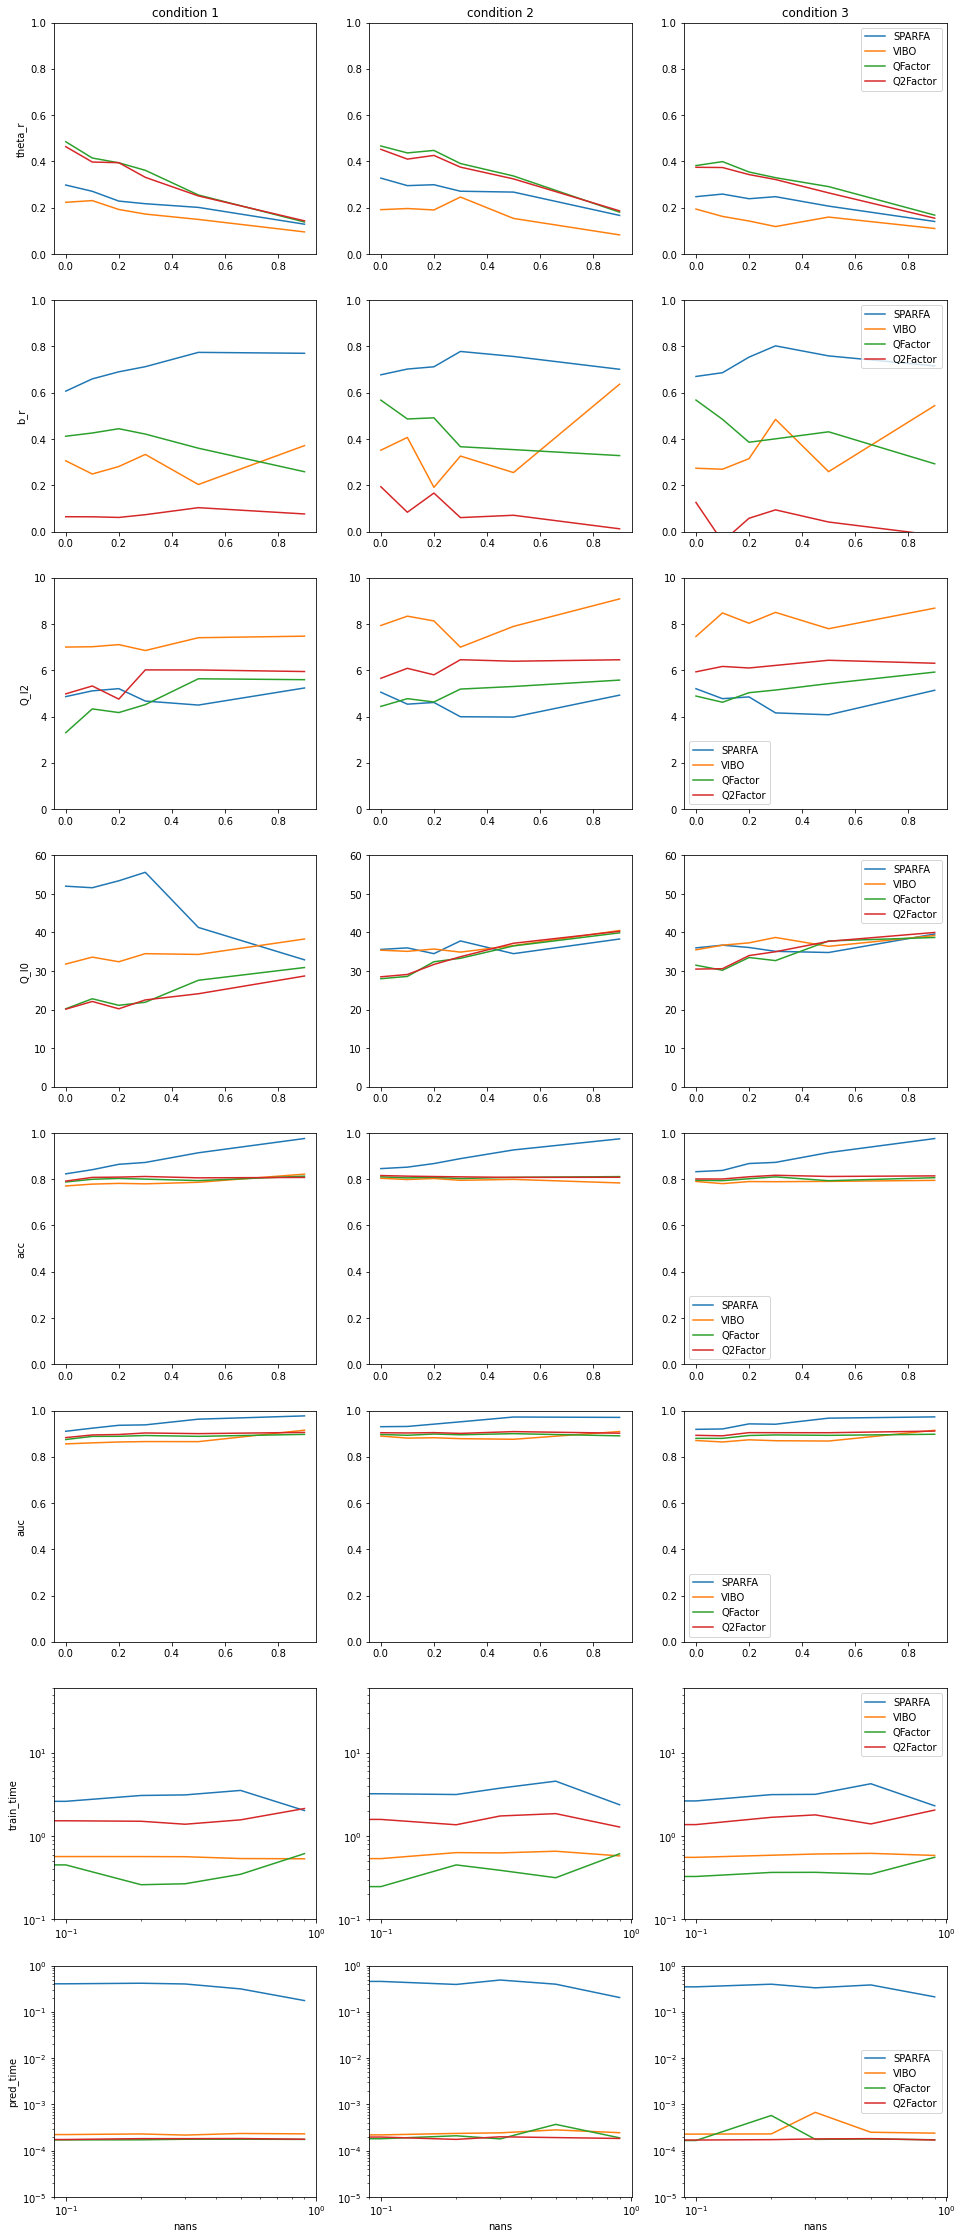

In [11]:
# plot for nans

exp_param_label = 'nans'
# the maximum y axis values for plotting for each evaluation measure
max_levels = [1., 1., 10., 60., 1., 1., 60., 1.]

plot_for_experimental_hyperparam(exp_param_label, max_levels)